Copyright @ cb_park@korea.ac.kr (Cheonbok Park), joonleesky@kaist.ac.kr (Hojoon Lee)

## MNIST Feed-Forward Neural Network

In [1]:
import torch 
import torch.nn as nn #
import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package 
import torchvision.datasets as vision_dsets
import torchvision.transforms as T # Transformation functions to manipulate images
import torch.optim as optim # various optimization functions for model
from torch.autograd import Variable 
from torch.utils import data

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2021-04-10 16:58:07--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-10 16:58:09--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [         <=>        ]  33.20M  2.98MB/s    in 22s     

2021-04-10 16:58:32 (1.49 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

## Initilaize Data Loader

In [3]:
def MNIST_DATA(root='./MNIST',train =True,transforms=None ,download =True,batch_size = 32,num_worker = 1):
    print ("[+] Get the MNIST DATA")
    """
    We will use Mnist data for our tutorial 
    """
    mnist_train = vision_dsets.MNIST(root = './',  #root is the place to store your data. 
                                    train = True,  
                                    transform = T.ToTensor(),
                                    download=False)
    mnist_test = vision_dsets.MNIST(root = './',
                                    train = False, 
                                    transform = T.ToTensor(),
                                    download=False)
    """
    Data Loader is a iterator that fetches the data with the number of desired batch size. 
    * Practical Guide : What is the optimal batch size? 
      - Usually.., higher the batter. 
      - We recommend to use it as a multiple of 2 to efficiently utilize the gpu memory. (related to bit size)
    """
    trainDataLoader = data.DataLoader(dataset = mnist_train,  # information about your data type
                                      batch_size = batch_size, # batch size
                                      shuffle =True, # Whether to shuffle your data for every epoch. (Very important for training performance)
                                      num_workers = 1) # number of workers to load your data. (usually number of cpu cores)

    testDataLoader = data.DataLoader(dataset = mnist_test, 
                                    batch_size = batch_size,
                                    shuffle = False, # we don't actually need to shuffle data for test
                                    num_workers = 1) #
    print ("[+] Finished loading data & Preprocessing")
    return mnist_train,mnist_test,trainDataLoader,testDataLoader

In [4]:
trainDset,testDset,trainDataLoader,testDataLoader= MNIST_DATA(batch_size = 32)  # Data Loader 

[+] Get the MNIST DATA
[+] Finished loading data & Preprocessing


## Define Trainer

In [5]:
class Trainer():
    def __init__(self, trainloader, testloader, net, optimizer, criterion):
        """
        trainloader: train data's loader
        testloader: test data's loader
        net: model to train
        optimizer: optimizer to update your model
        criterion: loss function
        """
        self.trainloader = trainloader
        self.testloader = testloader
        self.net = net
        self.optimizer = optimizer
        self.criterion = criterion
        
    def train(self, epoch = 1):
        """
        epoch: number of times each training sample is used
        """
        self.net.train()
        for e in range(epoch):
            running_loss = 0.0  
            for i, data in enumerate(self.trainloader, 0): 
                # get the inputs
                inputs, labels = data # Return type for data in dataloader is tuple of (input_data, labels)
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                self.optimizer.zero_grad()    
                #  Question 1) what if we dind't clear up the gradients?

                # forward + backward + optimize
                outputs = self.net(inputs) # get output after passing through the network
                loss = self.criterion(outputs, labels) # compute model's score using the loss function 
                loss.backward() # perform back-propagation from the loss
                self.optimizer.step() # perform gradient descent with given optimizer

                # print statistics
                running_loss += loss.item()
                if (i+1) % 500 == 0:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (e + 1, i + 1, running_loss / 500))
                    running_loss = 0.0

        print('Finished Training')
        
    def test(self):
        self.net.eval() # Question 2) Why should we change the network into eval-mode?
    
        test_loss = 0
        correct = 0
        for inputs, labels in self.testloader:
            inputs = inputs.cuda()
            labels = labels.cuda() 
            output = self.net(inputs) 
            pred = output.max(1, keepdim=True)[1] # get the index of the max 
            correct += pred.eq(labels.view_as(pred)).sum().item()

            test_loss /= len(self.testloader.dataset)
        print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.
                format(correct, len(self.testloader.dataset),
                100.* correct / len(self.testloader.dataset)))

## Let's create Model by yourself

![activation](./imgs/activation.png)

### Exp (1) 2-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [6]:
class MNIST_Net(nn.Module): 
    def __init__(self):
        super(MNIST_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) # x.view convert the shape of tensor, (Batch_size,28,28) --> (Batch_size,28*28)
        x = self.fc0(x) # 28*28 -> 30 
        x = F.sigmoid(x) # Activation function 
        x = self.fc1(x)  # 30 -> 10, logit for each class
        return x

In [7]:
mnist_net = MNIST_Net().cuda() # create the neural network instance and load to the cuda memory.
criterion = nn.CrossEntropyLoss() # Define Loss Function. We use Cross-Entropy loss.
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) # optimizer receives training parameters and learning rate.

In [8]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [9]:
trainer.train(epoch = 4)

/mnt/hdd/sultan/.local/lib/python3.6/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
[1,   500] loss: 2.330
[1,  1000] loss: 2.290
[1,  1500] loss: 2.268
[2,   500] loss: 2.238
[2,  1000] loss: 2.224
[2,  1500] loss: 2.208
[3,   500] loss: 2.181
[3,  1000] loss: 2.166
[3,  1500] loss: 2.149
[4,   500] loss: 2.118
[4,  1000] loss: 2.097
[4,  1500] loss: 2.080
Finished Training


In [10]:
trainer.test()


Test set:  Accuracy: 5385/10000 (54%)



### Exp (2) 2-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: 30
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [11]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) # Activation function
        x = self.fc1(x)  # 30 -> 10
        return x

In [12]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)

In [13]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [14]:
trainer.train(epoch = 4)

[1,   500] loss: 2.262
[1,  1000] loss: 2.166
[1,  1500] loss: 2.049
[2,   500] loss: 1.807
[2,  1000] loss: 1.641
[2,  1500] loss: 1.484
[3,   500] loss: 1.241
[3,  1000] loss: 1.119
[3,  1500] loss: 1.017
[4,   500] loss: 0.884
[4,  1000] loss: 0.830
[4,  1500] loss: 0.779
Finished Training


In [15]:
trainer.test()


Test set:  Accuracy: 8489/10000 (85%)



#### Question 3) Is there any difference in performance according to the activiation function?

### Exp (3) 3-Layer Network + Sigmoid

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: sigmoid
- Optimizer: SGD
- Loss: Cross-Entropy

In [16]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.sigmoid(x)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        return x

In [17]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001)  

In [18]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [19]:
trainer.train(epoch = 4)

[1,   500] loss: 2.311
[1,  1000] loss: 2.305
[1,  1500] loss: 2.303
[2,   500] loss: 2.301
[2,  1000] loss: 2.301
[2,  1500] loss: 2.300
[3,   500] loss: 2.299
[3,  1000] loss: 2.299
[3,  1500] loss: 2.300
[4,   500] loss: 2.298
[4,  1000] loss: 2.299
[4,  1500] loss: 2.299
Finished Training


In [20]:
trainer.test()


Test set:  Accuracy: 1135/10000 (11%)



### Exp (4) 3-Layer Network + ReLU

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: SGD
- Loss: Cross-Entropy

In [21]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [22]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(mnist_net.parameters(), lr=0.001) 

In [23]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [24]:
trainer.train(epoch = 4)

[1,   500] loss: 2.304
[1,  1000] loss: 2.290
[1,  1500] loss: 2.274
[2,   500] loss: 2.241
[2,  1000] loss: 2.214
[2,  1500] loss: 2.179
[3,   500] loss: 2.092
[3,  1000] loss: 2.019
[3,  1500] loss: 1.934
[4,   500] loss: 1.727
[4,  1000] loss: 1.590
[4,  1500] loss: 1.453
Finished Training


In [25]:
trainer.test()


Test set:  Accuracy: 7036/10000 (70%)



#### Question 4) Is training gets done easily in experiment (3),(4) compared to experiment (1),(2)? If it doesn't, why not?

#### Question 5) What would happen if there is no activation function?

## Let's Change our Optimizer

![Adam](./imgs/adam.jpeg)

Reference: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다

### Exp (5) 3-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [26]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [27]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [28]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [29]:
trainer.train(epoch = 4)

[1,   500] loss: 0.655
[1,  1000] loss: 0.292
[1,  1500] loss: 0.244
[2,   500] loss: 0.192
[2,  1000] loss: 0.173
[2,  1500] loss: 0.158
[3,   500] loss: 0.128
[3,  1000] loss: 0.134
[3,  1500] loss: 0.121
[4,   500] loss: 0.115
[4,  1000] loss: 0.104
[4,  1500] loss: 0.105
Finished Training


In [30]:
trainer.test()


Test set:  Accuracy: 9654/10000 (97%)



### Exp (6) 2-Layer Network + ReLU + Adam

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- Optimizer: Adam
- Loss: Cross-Entropy

In [31]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = F.relu(x) 
        x = self.fc1(x) 
        return x

In [32]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [33]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [34]:
trainer.train(epoch = 4)

[1,   500] loss: 0.697
[1,  1000] loss: 0.344
[1,  1500] loss: 0.295
[2,   500] loss: 0.255
[2,  1000] loss: 0.239
[2,  1500] loss: 0.216
[3,   500] loss: 0.198
[3,  1000] loss: 0.186
[3,  1500] loss: 0.188
[4,   500] loss: 0.161
[4,  1000] loss: 0.161
[4,  1500] loss: 0.146
Finished Training


In [35]:
trainer.test()


Test set:  Accuracy: 9563/10000 (96%)



## Batch-Normalization

![normalization](./imgs/normalization.png)

Reference: Andrew Ng, Deep Learning

### Exp (7) 2-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [36]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__() 
        # an affine operation: y = Wx + b
        self.fc0 = nn.Linear(28*28,30)
        self.bn0 = nn.BatchNorm1d(30) # BatchNorm 
        self.fc1 = nn.Linear(30, 10)

    def forward(self, x):
        x = x.view(-1,28*28) 
        x = self.fc0(x) # 28*28 -> 30 
        x = self.bn0(x)
        x = F.relu(x) 
        x = self.fc1(x)   
        return x

In [37]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)  

In [38]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [39]:
trainer.train(epoch = 4)

[1,   500] loss: 0.684
[1,  1000] loss: 0.326
[1,  1500] loss: 0.282
[2,   500] loss: 0.221
[2,  1000] loss: 0.203
[2,  1500] loss: 0.190
[3,   500] loss: 0.172
[3,  1000] loss: 0.158
[3,  1500] loss: 0.155
[4,   500] loss: 0.137
[4,  1000] loss: 0.146
[4,  1500] loss: 0.142
Finished Training


In [40]:
trainer.test()


Test set:  Accuracy: 9673/10000 (97%)



### Exp (8) 3-Layer Network + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Hidden dimension: (50, 30)
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [41]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28,50) # Layer 1
        self.bn0 = nn.BatchNorm1d(50) # BatchNorm 1 
        self.fc1 = nn.Linear(50, 30) # Layer 2
        self.bn1 = nn.BatchNorm1d(30) # BatchNorm 2
        self.fc2 = nn.Linear(30, 10) # Layer 3

    def forward(self, x):
      
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [42]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [43]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [44]:
trainer.train(epoch = 4)

[1,   500] loss: 0.659
[1,  1000] loss: 0.256
[1,  1500] loss: 0.201
[2,   500] loss: 0.146
[2,  1000] loss: 0.142
[2,  1500] loss: 0.133
[3,   500] loss: 0.105
[3,  1000] loss: 0.112
[3,  1500] loss: 0.112
[4,   500] loss: 0.093
[4,  1000] loss: 0.095
[4,  1500] loss: 0.104
Finished Training


In [45]:
trainer.test()


Test set:  Accuracy: 9744/10000 (97%)



#### Question 6) Is there any performance difference before/after applying the batch-norm?

## HW 1.1 Let's Do It: Let's achieve performance greater than 97%!

DIY network: 4-Layer Network + ReLU + Adam + Batch-Norm
-   Input: (28*28)
-   Hidden Dimension: (100, 70, 40)
-   Output dimension: 10 
-   Activation: ReLU
-   Normalization: Batch-Norm
-   Optimizer: Adam
-   Loss: Cross-Entropy

In [46]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc0 = nn.Linear(28*28, 100) # Layer 1
        self.bn0 = nn.BatchNorm1d(100) # Batchnorm 1
        self.fc1 = nn.Linear(100, 70) # Layer 2
        self.bn1 = nn.BatchNorm1d(70) # Batchnorm 2
        self.fc2 = nn.Linear(70, 40) # Layer 3
        self.bn2 = nn.BatchNorm1d(40) # Batchnorm 3
        self.fc3 = nn.Linear(40, 10) # Layer 4

    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc0(x)
        x = self.bn0(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [47]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [48]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)
trainer.train(epoch = 4)

[1,   500] loss: 0.532
[1,  1000] loss: 0.228
[1,  1500] loss: 0.178
[2,   500] loss: 0.137
[2,  1000] loss: 0.126
[2,  1500] loss: 0.118
[3,   500] loss: 0.100
[3,  1000] loss: 0.100
[3,  1500] loss: 0.095
[4,   500] loss: 0.078
[4,  1000] loss: 0.085
[4,  1500] loss: 0.082
Finished Training


In [49]:
trainer.test()


Test set:  Accuracy: 9793/10000 (98%)



In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(mnist_net)

89240

tensor([[9.9184e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0408e-03,
         1.0204e-03, 1.0204e-03, 3.0612e-03, 1.0204e-03],
        [0.0000e+00, 9.9295e-01, 0.0000e+00, 1.7621e-03, 0.0000e+00, 0.0000e+00,
         8.8106e-04, 8.8106e-04, 3.5242e-03, 0.0000e+00],
        [2.9070e-03, 1.9380e-03, 9.8159e-01, 1.9380e-03, 9.6899e-04, 9.6899e-04,
         0.0000e+00, 4.8450e-03, 4.8450e-03, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.9802e-03, 9.7426e-01, 0.0000e+00, 1.6832e-02,
         9.9010e-04, 3.9604e-03, 9.9010e-04, 9.9010e-04],
        [1.0183e-03, 0.0000e+00, 1.0183e-03, 0.0000e+00, 9.6232e-01, 1.0183e-03,
         8.1466e-03, 3.0550e-03, 1.0183e-03, 2.2403e-02],
        [2.2422e-03, 1.1211e-03, 0.0000e+00, 2.2422e-03, 1.1211e-03, 9.8543e-01,
         4.4843e-03, 1.1211e-03, 1.1211e-03, 1.1211e-03],
        [6.2630e-03, 2.0877e-03, 0.0000e+00, 0.0000e+00, 1.0438e-03, 3.1315e-03,
         9.8539e-01, 1.0438e-03, 1.0438e-03, 0.0000e+00],
        [9.7276e-04, 2.9183

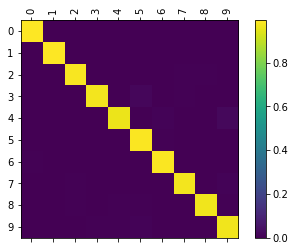

In [51]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy

# Plot the confusion matrix
n_label = 10 # Digits from 0 to 9
confusion = torch.zeros(n_label, n_label)
for inputs, labels in trainer.testloader:
    inputs = inputs.cuda()
    labels = labels.cuda()
    output = trainer.net(inputs) 
    pred = output.max(1, keepdim=True)[1] # get the index of the max
    for i in range(len(labels)):
        confusion[labels[i].item()][pred[i].item()] += 1
for j in range(n_label):
    confusion[j] = confusion[j] / confusion[j].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticks(range(10))
ax.set_xticklabels(range(10), rotation=90)
ax.set_yticks(range(10))
ax.set_yticklabels(range(10))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.savefig('confusion1')

# Perform analysis on the MNIST confusion matrix
print(confusion) 

#### Question 7) What may be the potential problems when training the neural network with a large number of parameters?

## Let's use Convolution Layer

### Convolution Operation

![Convolution](./imgs/Conv.png)



#### Question 8) Given input image with shape:(H, W, C1), what would be the shape of output image after applying 2 (F * F) convolutional filters with stride S?

### (9) 3-Layer Network (Conv+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (6 * 6) filter with stride=2 
- Hidden dimension: 8 * 12 * 12
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

In [52]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  # 2d batch-norm is used in 3d inputs
        self.fc = nn.Linear(8*12*12, 10)   # Layer 2 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [53]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001)

In [54]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [55]:
trainer.train(epoch = 4)

[1,   500] loss: 0.399
[1,  1000] loss: 0.173
[1,  1500] loss: 0.142
[2,   500] loss: 0.086
[2,  1000] loss: 0.090
[2,  1500] loss: 0.083
[3,   500] loss: 0.063
[3,  1000] loss: 0.066
[3,  1500] loss: 0.070
[4,   500] loss: 0.052
[4,  1000] loss: 0.056
[4,  1500] loss: 0.055
Finished Training


In [56]:
trainer.test()


Test set:  Accuracy: 9823/10000 (98%)



In [57]:
count_parameters(mnist_net)

11842

#### Question 9) How did the performance and the number of parameters change after using the Convolution operation? Why did these results come out?

### (10) 3-Layer Network (Conv+Pool+Fc) + ReLU + Adam + Batch-Norm

- Input: (28 * 28)
- Conv: 8 (7 * 7) filter with stride=2 
- Pool: 2 * 2
- Hidden dimension: 8 * 6 * 6
- Output dimension: 10
- activation: relu
- normalization: batch-norm
- Optimizer: Adam
- Loss: Cross-Entropy

### Pooling Operation

![Pooling](./imgs/Pool.png)



In [58]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1,
                               out_channels = 8,
                               kernel_size = 6,
                               stride = 2) # Layer 1
        self.conv0_bn = nn.BatchNorm2d(8)  
        self.pool0 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8*6*6, 10) 

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = F.relu(x)
        x = self.pool0(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [59]:
mnist_net = MNIST_Net().cuda() 
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(mnist_net.parameters(), lr=0.001) 

In [60]:
trainer = Trainer(trainloader = trainDataLoader,
                  testloader = testDataLoader,
                  net = mnist_net,
                  criterion = criterion,
                  optimizer = optimizer)

In [61]:
trainer.train(epoch = 4)

[1,   500] loss: 0.547
[1,  1000] loss: 0.204
[1,  1500] loss: 0.153
[2,   500] loss: 0.112
[2,  1000] loss: 0.116
[2,  1500] loss: 0.101
[3,   500] loss: 0.087
[3,  1000] loss: 0.090
[3,  1500] loss: 0.085
[4,   500] loss: 0.077
[4,  1000] loss: 0.076
[4,  1500] loss: 0.075
Finished Training


In [62]:
trainer.test()


Test set:  Accuracy: 9788/10000 (98%)



In [63]:
count_parameters(mnist_net)

3202

#### Question 10) How did the performance change after using the Pooling operation? Why did these results come out?